In [81]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from scipy import signal
from astroquery.mast import Observations
import lightkurve as lk
from astropy.timeseries import LombScargle
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator


In [82]:
def make_cmap(colors, position, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    bit_rgb = np.linspace(0,1,256)
    # if position == None:
    #     position = np.linspace(0,1,len(colors))
    # else:
    if len(position) != len(colors):
        sys.exit("position length must be the same as colors")
    elif position[0] != 0 or position[-1] != 1:
        sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap
def choose_cmap(custom_cmap, reverse_cmap=False):

    custom_cmaps = {'my diverging red blue': [(204/255, 230/255, 255/255),
                                              (0/255, 102/255, 204/255),
                                              (51/255, 0/255, 102/255),
                                              (255/255, 0/255, 102/255),
                                              (255/255, 230/255, 243/255)],
                    'my blue yellow red': [(0 / 255, 74 / 255, 171 / 255),
                                        (255 / 255, 209 / 255, 26 / 255),
                                        (178 / 255, 0 / 255, 3 / 255)],
                    'McLaren 2022': [(0/255, 38/255, 77/255),
                                    (211/255, 0/255, 87/255),
                                    (255/255, 153/255, 0/255),
                                    (191/255, 217/255, 217/255)],
                    'vibrant candy': [(0/255, 26/255, 77/255),
                                    (204/255, 0/255, 102/255),
                                    (255/255, 204/255, 0/255),
                                    (153/255, 255/255, 153/255)],
                    'ice queen': [(37/255, 0/255, 51/255),
                                  (0/255, 155/255, 153/255),
                                  (214/255, 255/255, 214/255)],
                    'ice queen2': [(0/255, 0/255, 0/255),
                                   (0/255, 134/255, 179/255),
                                   (255/255, 255/255, 200/255)],
                    'amazon queen': [(0/255, 0/255, 0/255),
                                     (25/255, 103/255, 103/255),
                                     (119/255, 179/255, 105/255),
                                     (255/255, 234/255, 0/255),
                                     (255/255, 255/255, 255/255)],
                    'amazon queen2': [(0/255, 34/255, 51/255),
                                      (25/255, 103/255, 103/255),
                                    #   (119/255, 179/255, 105/255),
                                    #   (63/255, 211/255, 146/255),
                                      (255/255, 234/255, 0/255)],
                    'colorado sunrise': [(0/255, 17/255, 51/255),
                                         (234/255, 74/255, 104/255),
                                         (255/255, 224/255, 102/255)],
                    'muted rbg': [(102/255, 0/255, 51/255),
                                  (0/255, 85/255, 128/255),
                                  (140/255, 153/255, 0/255)],
                    'perceptual rbg': [(102/255, 0/255, 51/255),
                                       (60/255, 40/255, 90/255),
                                       (0/255, 102/255, 153/255),
                                       (134/255, 179/255, 0/255),
                                       (255/255, 200/255, 50/255),
                                       (255/255, 255/255, 160/255)],
                    'mclaren livery': [(0/255, 119/255, 179/255),
                                       (204/255, 0/255, 102/255),
                                    #    (255/255, 128/255, 0/255),
                                       (255/255, 153/255, 0/255),
                                       (207/255, 226/255, 226/255)],
                    'volcanic sunrise': [(0/255, 51/255, 77/255),
                                  (153/255, 0/255, 77/255),
                                  (255/255, 80/255, 80/255),
                                  (255/255, 255/255, 153/255)],
                    'cyber grape': [(51/255, 0/255, 51/255),
                                    (128/255, 0/255, 128/255),
                                    (153/255, 102/255, 255/255),
                                    (204/255, 255/255, 255/255)],
                    'cyber grape2': [(51/255, 0/255, 51/255),
                                     (128/255, 0/255, 128/255),
                                     (255/255, 153/255, 204/255),
                                     (204/255, 255/255, 255/255)],
                    'black limeaid': [(0/255, 0/255, 77/255),
                                      (102/255, 153/255, 153/255),
                                      (204/255, 255/255, 51/255)],
                    }

    chosen_cmap = custom_cmaps[custom_cmap]
    pos_diff = 1./(len(chosen_cmap)-1)
    positions = np.arange(0, 1+pos_diff, pos_diff)
    if reverse_cmap == True:
        chosen_cmap = chosen_cmap[::-1]
    mycolormap = make_cmap(chosen_cmap, position=positions)

    return mycolormap
def unique(list_of_values):
    unique_values = []
    for _, value in enumerate(list_of_values):
        if value in unique_values:
            pass
        else:
            unique_values.append(value)
    return unique_values
def bindat(time_x, data_y, data_yerr, bin_window):
    """
    Bins timeseries data to a given time window "bintime". Units of time are in days. 
    ----------
    time_x : array_like
        Array containing time in units of days
    data_y : array_like
        Array containing data taken at each time.
    data_yerr: array_like
        Array containing uncertainties on the data
    bin_window: float
        Scalar value of the time window the data should be binned within
    
    Returns
    -------
    out_time_x: array_like
        Array containing average time for measurements within the associated bin
    out_data_y: array_like
        Array containing binned data
    out_data_yerr: array_like
        Array containing uncertaintiies on the binned data
    """

    time_x = np.array(time_x)
    data_y = np.array(data_y)
    data_yerr = np.array(data_yerr)

    bin_time = []
    bin_data = []
    num_bins = int((max(time_x) - min(time_x)) / bin_window)
    for i in range(num_bins+1):
        bin_start, bin_stop = time_x[0] + i * bin_window, time_x[0] + (i + 1) * bin_window
        temp_time = time_x[(time_x >= bin_start) & (time_x < bin_stop)]
        temp_data = data_y[(time_x >= bin_start) & (time_x < bin_stop)]
        if len(temp_time) > 0:
            bin_time.append(np.mean(temp_time))
            bin_data.append(np.mean(temp_data))
    out_time_x = np.array(bin_time)
    out_data_y = np.array(bin_data)
    out_data_yerr = np.array([])

    # print(out_time_x)
    # print(out_data_y)

    return out_time_x, out_data_y, out_data_yerr
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
def identify_period(periods, powers, fit_range=1, range_restriction=None, do_plot=False):

    if range_restriction != None:
        powers = powers[(periods >= range_restriction[0]) & (periods <= range_restriction[1])]
        periods = periods[(periods >= range_restriction[0]) & (periods <= range_restriction[1])]

    # Find the highest peak
    max_idx = np.argmax(powers)
    peak_period = periods[max_idx]

    # Define a range around the peak for fitting
    # You can adjust the range to ensure neighboring peaks don't influence the fit
    # fit_range = 0.5  # for example, 0.5 units on either side of the peak
    fit_mask = (periods > peak_period - fit_range) & (periods < peak_period + fit_range)

    # Fit the Gaussian
    popt, pcov = curve_fit(gaussian, periods[fit_mask], powers[fit_mask], p0=[powers[max_idx], peak_period, 0.1])

    fit_period = popt[1]
    fit_sigma = popt[2]

    x_fit = np.linspace(peak_period - fit_range, peak_period + fit_range, 1000)
    y_fit = gaussian(x_fit, *popt)

    if fit_period > periods[-1]:
        do_plot = True

    # Plot the results
    if do_plot == True:
        fig_test = plt.figure(figsize=(6.5, 4.5))
        ax_test = fig_test.add_subplot(111)
        ax_test.plot(periods, powers, color='black', label='Periodogram')
        ax_test.plot(x_fit, y_fit, label='Gaussian Fit', color='red')
        ax_test.text(0.05, 0.90, '{:.2f} +/- {:.2f} d'.format(fit_period, fit_sigma), horizontalalignment='left', verticalalignment='bottom', transform=ax_test.transAxes)
        ax_test.set_xlabel('Period (d)')
        ax_test.set_ylabel('Power')
        # ax_test.set_title('Gaussian Fit to the Highest Peak in Periodogram')
        # ax_test.legend()
        plt.show()

    return fit_period, fit_sigma



plt.style.use('/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle')

Bad value in file '/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle', line 17 ("mathtext.fallback: dejavsans  # Select fallback font from ['cm' (Computer Modern), 'stix'"): Key mathtext.fallback: dejavsans is not a valid fallback font name. Valid fallback font names are cm,stix,stixsans. Passing 'None' will turn fallback off.


In [83]:
def set_minmax_per(mission_str, target, xdat):
    min_per = 0.05 # days
    # if mission_str == 'K2':
    #     max_per = 16  
    # if mission_str == 'TESS':
    #     max_per = 12
    max_per_ceil = 25.0
    max_per_floor = 12.0
    max_per = np.ceil(0.20*(xdat[-1] - xdat[0]))
    if max_per > max_per_ceil:
        max_per = max_per_ceil
    if max_per < max_per_floor:
        max_per = max_per_floor

    if target == 'HP Tau':
        max_per_id = 3.0
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id
    elif target == 'DO Tau':
        if mission_str == 'TESS':
            max_per_id = 4.0
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        if mission_str == 'K2':
            max_per_id = 13.0
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
    elif target == 'DR Tau':
        if mission_str == 'K2':
            max_per_id = 20
            max_per = 20
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        if mission_str == 'TESS':
            max_per_id = max_per
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
    elif target == 'Haro 6-13':
        max_per_id = 7
        max_per = 7
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id
    elif target == '2MASS J16090141-3925119':
        max_per_id = max_per
        max_per = max_per
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id
    elif target == 'Sz 111':
        max_per_id = 9
        max_per = 10
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id
    elif target == '2MASS J16271382-2443316':
        max_per_id = 6.0
        max_per = 16
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id
    elif target == '2MASS J16030161-2207523':
        max_per_id = 1.0
        max_per = 16
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id
    elif target == '2MASS J16062383-1807183':
        max_per_id = 5.0
        max_per = 16
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id
    elif target == 'Elias 2-20':
        max_per_id = 6.0
        max_per = 16
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id
    elif target == 'VSSG 4':
        max_per_id = 7.0
        max_per = 16
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id
    elif target == 'WL 18':
        max_per_id = 7.0
        max_per = 16
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id
    elif target == '2MASS J16102955-3922144':
        max_per_id = 1.5
        max_per = 16
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id
    elif target == 'CY Tau':
        max_per_id = 8.0
        max_per = 16
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id
    elif target == 'FM Tau':
        max_per_id = 16.0
        max_per = 16
        min_per_id = 4.0
        gauss_fit_range = 0.1 * max_per_id
    elif target == 'Sz 110':
        max_per_id = 1.5
        max_per = 16
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id
    elif target == '2MASS J16105158-3853137':
        max_per_id = 2.0
        max_per = 16.0
        min_per_id = 0.20
        gauss_fit_range = 0.05
    elif target == 'DL Tau':
        max_per_id = 12
        max_per = 12
        min_per_id = 0.20
        gauss_fit_range = 0.05 * max_per_id
    elif target == 'AA Tau':
        if mission_str == 'K2':
            max_per_id = max_per  # 4.5
            max_per = max_per  # 16
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        if mission_str == 'TESS':
            max_per_id = max_per  # 6.0
            max_per = max_per
            min_per_id = 5.0
            gauss_fit_range = 0.1 * max_per_id
    elif target == 'CI Tau':
        if mission_str == 'K2':
            max_per_id = max_per  # 4.5
            max_per = max_per  # 16
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        if mission_str == 'TESS':
            max_per_id = max_per  # 6.0
            max_per = max_per
            min_per_id = 8.0
            gauss_fit_range = 0.1 * max_per_id
    elif target == 'SU Aur':
        if mission_str == 'K2':
            max_per_id = max_per  # 4.5
            max_per = max_per  # 16
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        if mission_str == 'TESS':
            max_per_id = max_per  # 6.0
            max_per = 5.0
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
    elif target == '2MASS J04334465+2615005':
        if mission_str == 'K2':
            max_per_id = max_per  # 4.5
            max_per = max_per  # 16
            min_per_id = min_per
            gauss_fit_range = 0.03 * max_per_id
        if mission_str == 'TESS':
            max_per_id = max_per  # 6.0
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.03 * max_per_id
    elif target == 'RU Lup':
        if mission_str == 'K2':
            max_per_id = 6.0
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        if mission_str == 'TESS':
            max_per_id = 6.0
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
    elif target == 'RY Lup':
        if mission_str == 'K2':
            max_per_id = max_per
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        if mission_str == 'TESS':
            max_per_id = 10
            max_per = 10
            min_per_id = min_per
            gauss_fit_range = 0.05 * max_per_id
    elif target == 'RY Tau':
        if mission_str == 'K2':
            max_per_id = max_per
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        if mission_str == 'TESS':
            max_per_id = 10
            max_per = 10
            min_per_id = min_per
            gauss_fit_range = 0.03 * max_per_id
    elif target == '2MASS J16020757-2257467':
        if mission_str == 'K2':
            max_per_id = 5
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.03 * max_per_id
        if mission_str == 'TESS':
            max_per_id = 10
            max_per = 10
            min_per_id = min_per
            gauss_fit_range = 0.03 * max_per_id
    elif target == 'Sz 98':
        if mission_str == 'K2':
            max_per_id = max_per
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        if mission_str == 'TESS':
            max_per_id = 14
            max_per = 14
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
    elif target == 'Sz 113':
        if mission_str == 'K2':
            max_per_id = max_per
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        if mission_str == 'TESS':
            max_per_id = 14
            max_per = 14
            min_per_id = min_per
            gauss_fit_range = 0.03 * max_per_id
    elif target == 'Sz 61':
        if mission_str == 'K2':
            max_per_id = max_per
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        if mission_str == 'TESS':
            max_per_id = 8.6
            max_per = 14
            min_per_id = 4
            gauss_fit_range = 0.1 * max_per_id
    elif target == '2MASS J04360131+1726120':
        if mission_str == 'K2':
            max_per_id = max_per
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        if mission_str == 'TESS':
            max_per_id = max_per
            max_per = max_per
            min_per_id = 1.8
            gauss_fit_range = 0.03 * max_per_id
    elif target == '2MASS J16154416-1921171':
        if mission_str == 'K2':
            max_per_id = max_per
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        if mission_str == 'TESS':
            max_per_id = max_per
            max_per = max_per
            min_per_id = 1.8
            gauss_fit_range = 0.03 * max_per_id
    elif target == 'Sz 76':
        if mission_str == 'K2':
            max_per_id = max_per
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        if mission_str == 'TESS':
            max_per_id = 2
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
    elif target == 'EM* SR 4':
        if mission_str == 'K2':
            max_per_id = 10
            max_per = 10
            min_per_id = min_per
            gauss_fit_range = 0.03 * max_per_id
        if mission_str == 'TESS':
            max_per_id = max_per
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
    elif target == '2MASS J04141760+2806096':
        if mission_str == 'K2':
            max_per_id = max_per
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.03 * max_per_id
        if mission_str == 'TESS':
            max_per_id = max_per
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.01 * max_per_id
    elif target == 'V409 Tau':
        max_per_id = 12
        max_per = 12
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id
    elif target == 'LkHa 358':
        if mission_str == 'K2':
            max_per_id = 12
            max_per = 12
            min_per_id = min_per
            gauss_fit_range = 0.03 * max_per_id
        if mission_str == 'TESS':
            max_per_id = max_per
            max_per = max_per
            min_per_id = min_per
            gauss_fit_range = 0.01 * max_per_id
    elif target == '2MASS J16042165-2130284':
        max_per_id = max_per
        max_per = max_per
        min_per_id = min_per
        gauss_fit_range = 0.03 * max_per_id
    # elif target == 'RX J1556.0-3655':
    #     max_per_id = max_per
    #     max_per = max_per
    #     min_per_id = 7
    #     gauss_fit_range = 0.03 * max_per_id



    else:
        max_per_id = max_per
        min_per_id = min_per
        gauss_fit_range = 0.1 * max_per_id

    return min_per, max_per, min_per_id, max_per_id, gauss_fit_range

def compute_periodogram_and_phase_curve(lcv_x, lcv_y, lcv_y_err, mission_str, target, plot_period_identification):

    # ----------------- PERIODOGRAM -------------------- #

    min_per, max_per, min_per_id, max_per_id, gauss_fit_range = set_minmax_per(mission_str, target, lcv_x)

    period_resolution = 0.01
    period = np.arange(min_per, max_per + period_resolution, period_resolution)
    frequency = 1. / period
    power = LombScargle(t=lcv_x, y=lcv_y, dy=lcv_y_err).power(frequency)

    peak_signal = identify_period(period, power, fit_range=gauss_fit_range, range_restriction=[min_per_id, max_per_id], do_plot=plot_period_identification)

    periodogram_table = {'frequency': frequency,
                        'period': period,
                        'power': power,
                        }

    per_x = periodogram_table['period']
    per_y = periodogram_table['power']

    # ----------------- PHASE FOLD -------------------- #

    lcv_x_pse = lcv_x - lcv_x[0]
    pse_x = np.mod(lcv_x_pse, peak_signal[0]) / peak_signal[0]
    pse_x_binned, pse_y_binned, pse_y_err_binned = bindat(time_x=pse_x, data_y=lcv_y, data_yerr=[0]*len(lcv_y), bin_window=0.075)

    return per_x, per_y, peak_signal, pse_x, lcv_y, pse_x_binned, pse_y_binned, pse_y_err_binned
    


In [84]:
def clean_lightcurve(xdata, ydata, ydata_err, itime, which_target, which_telescope, do_clean, do_plot=False):

    do_tests_for_tom = False
    if do_tests_for_tom == True:
        if which_target == '2MASS J15562477-2225552':
            window_length_in_days = 1.5
        if which_target == 'V836 Tau':
            window_length_in_days = 1.5
        if which_target == 'DN Tau':
            window_length_in_days = 1.5
        if which_target == 'RX J1615.3-3255':
            window_length_in_days = 1.0
        if which_target == 'MP Mus':
            window_length_in_days = 1.0
        if which_target == '2MASS J11004022-7619280':
            window_length_in_days = 1.0
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆                         ∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆   DOING TESTS FOR TOM   ∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆   WINDOW LENGTH = ' + str(round(window_length_in_days,1)) + '   ∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆                         ∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        
    else:
        if which_telescope == 'TESS':

            window_length_in_days = 0.75

            if which_target in ['IM Lup', 'MY Lup', 'RX J1615.3-3255', 'RY Lup', 'SY Cha',
                                '2MASS J11120327-7637034', 'Sz 76', 'Sz 77', 'Sz 58',
                                'Sz 61', 'LkHa 330', 'Sz 111', 'Sz 84', 'RY Tau', 'DS Tau',
                                'Ass Cha T 1-27']:
                window_length_in_days = 0.01
            if which_target in ['V1094 Sco', '2MASS J04141760+2806096', '2MASS J04334465+2615005', '2MASS J04141760+2806096']:
                window_length_in_days = 0.15
            if which_target in ['Sz 130', 'V1094 Sco', '2MASS J16083070-3828268', 'Sz 90',
                                '2MASS J16124373-3815031', '2MASS J16000236-4222145', 'CT Cha', 'RX J1556.0-3655']:
                window_length_in_days = 0.30
        
        if which_telescope == 'K2':
            window_length_in_days = 0.5
            if which_target in ['2MASS J16083070-3828268', '2MASS J16163345-2521505',
                                '2MASS J16154416-1921171', '2MASS J04141760+2806096']:
                window_length_in_days = 0.10
            if which_target in ['2MASS J16081566-2222199']:
                window_length_in_days = 1.5
        
    order_polynomial = 3  # 2


    window_length_in_n_points = int(window_length_in_days / (itime/86400))

    segments_x = []
    segments_y = []

    if which_target == '2MASS J11004022-7619280':
        gap_thres = 0.5
    else:
        gap_thres = 1  # days
    where_gap = np.where(np.diff(xdata[0:-1] - xdata[1::]) > gap_thres)[0]


    if which_telescope == 'TESS':
        if which_target in ['IM Lup', 'MP Mus', 'MY Lup', 'RY Lup', 'SY Cha', 'Sz 130', 'RX J1615.3-3255', 'CW Tau']:
            trim_amount_in_days = 0.01
        else:
            trim_amount_in_days = 0.10
    if which_telescope == 'K2':
        if which_target in ['DoAr 25']:
            trim_amount_in_days = 0.10
        else:
            trim_amount_in_days = 1.0
        

    trim_amount = int(trim_amount_in_days / (itime/86400))   # trip ends of segments by 0.25 days


    new_xdata = []
    new_ydata = []
    new_ydata_err = []

    if len(where_gap) > 0:
        gap_caps = [0]
        for gap_i in range(len(where_gap)):
            gap_caps.append(where_gap[gap_i])
            gap_caps.append(where_gap[gap_i] + 1)
        gap_caps.append(len(xdata)-1)
        gap_starts = gap_caps[0::2]
        gap_stops = gap_caps[1::2]

        # print(gap_caps)
        # print('starts ', gap_starts)
        # print('stops ', gap_stops)
        # print(' ')

        if which_telescope == 'TESS':
            length_limit = 2.5
        if which_telescope == 'K2':
            length_limit = 5.0
        
        for gap_i in range(len(gap_starts)):

            gap_start = gap_starts[gap_i]  # + 2*window_length_in_n_points
            gap_stop = gap_stops[gap_i]  # - 2*window_length_in_n_points

            seg_x = xdata[(xdata >= xdata[gap_start]) & (xdata <= xdata[gap_stop])]
            seg_y = ydata[(xdata >= xdata[gap_start]) & (xdata <= xdata[gap_stop])]
            seg_y_err = ydata_err[(xdata >= xdata[gap_start]) & (xdata <= xdata[gap_stop])]

            seg_x = seg_x[trim_amount:-trim_amount]
            seg_y = seg_y[trim_amount:-trim_amount]
            seg_y_err = seg_y_err[trim_amount:-trim_amount]

            if abs(seg_x[-1] - seg_x[0]) > length_limit:

                seg_y /= np.median(seg_y)
                seg_y_err /= np.median(seg_y_err)

                new_xdata.extend(seg_x)
                new_ydata.extend(seg_y)
                new_ydata_err.extend(seg_y_err)

                segments_x.append(seg_x)
                segments_y.append(seg_y)
    else:
        seg_x = xdata[trim_amount:-trim_amount]
        seg_y = ydata[trim_amount:-trim_amount]
        seg_y_err = ydata_err[trim_amount:-trim_amount]

        seg_y /= np.median(seg_y)
        seg_y_err /= np.median(seg_y_err)

        new_xdata.extend(seg_x)
        new_ydata.extend(seg_y)
        new_ydata_err.extend(seg_y_err)

        segments_x.append(seg_x)
        segments_y.append(seg_y)


    new_xdata = np.array(new_xdata)
    new_ydata = np.array(new_ydata)
    new_ydata_err = np.array(new_ydata_err)




    if do_plot == True:
        fig_bep = plt.figure(figsize=(12, 5))
        ax = fig_bep.add_subplot(111)
        for segment_i in range(len(segments_x)):
            ax.plot(segments_x[segment_i], segments_y[segment_i])
        plt.show()


    low_passed_ydata = []
    high_passed_ydata = []

    for segment_j in range(len(segments_x)):
        # Apply low-pass Savitzky-Golay filter
        low_passed_y_segment = savgol_filter(np.array(segments_y[segment_j]), window_length=window_length_in_n_points, polyorder=order_polynomial)
        low_passed_ydata.extend(low_passed_y_segment)
        # Subtract the low-pass filtered data from the original data to get high-pass data
        high_passed_ydata.extend(np.array(segments_y[segment_j]) - np.array(low_passed_y_segment))


    
    std_factor = 3

    if which_telescope == 'K2':
        if which_target in ['DoAr 25']:
            std_factor = 10000000
        if which_target in ['2MASS J16154416-1921171', '2MASS J16081566-2222199']:
            std_factor = 1
        if which_target in ['2MASS J16163345-2521505']:
            std_factor = 0.05

    if do_clean == False:
        std_factor = 20


    clipped_xdata = new_xdata[(high_passed_ydata >= -std_factor*np.std(high_passed_ydata)) & (high_passed_ydata <= std_factor*np.std(high_passed_ydata))]
    clipped_ydata = new_ydata[(high_passed_ydata >= -std_factor*np.std(high_passed_ydata)) & (high_passed_ydata <= std_factor*np.std(high_passed_ydata))]
    clipped_ydata_err = new_ydata_err[(high_passed_ydata >= -std_factor*np.std(high_passed_ydata)) & (high_passed_ydata <= std_factor*np.std(high_passed_ydata))]
    clipped_low_passed_ydata = np.array(low_passed_ydata)[(high_passed_ydata >= -std_factor*np.std(high_passed_ydata)) & (high_passed_ydata <= std_factor*np.std(high_passed_ydata))]


    if do_plot == True:

        if do_tests_for_tom == False:
            grid_width = 1
            grid_height = 2

            quickfig = plt.figure(figsize=(12,5), dpi=150)
            gs = gridspec.GridSpec(grid_height , grid_width , height_ratios=[1.5, 0.25], wspace=0.08, hspace=0.05)
            axes = [quickfig.add_subplot(gs[ii, jj]) for ii in range(grid_height) for jj in range(grid_width)]
            ax1 = axes[0]
            ax2 = axes[1]

            ax1.scatter(new_xdata, new_ydata, color='grey', s=np.pi*(2)**2, zorder=0)
            ax1.plot(new_xdata, low_passed_ydata, color='red', lw=1.5, alpha=0.5, zorder=2)
            ax1.scatter(clipped_xdata, clipped_ydata, color='orange', s=np.pi*(1.5)**2, alpha=1, zorder=1)
            ax1.set_xticklabels([])

            ax2.scatter(new_xdata, np.array(low_passed_ydata) - np.array(new_ydata), color='grey', s=np.pi*(2)**2, zorder=0)
            ax2.plot(new_xdata, [0]*len(low_passed_ydata), color='red', lw=1.5, alpha=0.5, zorder=2)
            ax2.scatter(clipped_xdata, np.array(clipped_low_passed_ydata) - np.array(clipped_ydata), color='orange', s=np.pi*(1.5)**2, alpha=1, zorder=1)

            # if which_target == '2MASS J04334465+2615005':
            #     ax1.set_ylim(0.75, 1.25)
            #     ax2.set_ylim(0.75, 1.25)

            plt.show()
        
        else:
            grid_width2 = 1
            grid_height2 = 2

            quickfig2 = plt.figure(figsize=(8,5), dpi=150)
            gs = gridspec.GridSpec(grid_height2 , grid_width2 , height_ratios=[1, 1], wspace=0.08, hspace=0.05)
            axes = [quickfig2.add_subplot(gs[ii, jj]) for ii in range(grid_height2) for jj in range(grid_width2)]
            ax1 = axes[0]
            ax2 = axes[1]

            ax1.plot(new_xdata, new_ydata, color='grey', lw=2, label='ydata', zorder=0)
            ax1.plot(new_xdata, low_passed_ydata, color='purple', lw=2, label='low passed data', zorder=1)

            ax1.set_xticklabels([])

            ax2.plot(new_xdata, np.array(new_ydata)/np.array(low_passed_ydata), color='#000000', lw=2, zorder=0)

            ax1.legend()

            if which_target == '2MASS J15562477-2225552':
                xmin, xmax = 2089-2, 2089+2
                ax1.set_xlim(xmin, xmax)
                ax2.set_xlim(xmin, xmax)
                ax1.set_ylim(0.99, 1.025)
                ax2.set_ylim(0.99, 1.015)

            plt.show()

    return clipped_xdata, clipped_ydata, clipped_ydata_err



In [85]:
def identify_page_breaks(target_lc_data):

    plot_targets = list(target_lc_data.keys())
    
    targ_heights = []
    for targ in plot_targets:

        targ_dict = target_lc_data[targ]
        targ_missions = list(targ_dict.keys())
        grid_height = len(targ_missions)

        if grid_height == 1:
            targ_heights.append(3.2)
        if grid_height == 2:
            targ_heights.append(6.1)
        if grid_height == 3:
            targ_heights.append(9.0)

    print('len_total: ', len(targ_heights))
    print('max height:, ', 13.0 * 1.5)

    page_breaks = []
    break_index = []
    marker_i1 = 0
    while marker_i1 < len(targ_heights):
        if marker_i1 == 0:
            page_breaks.append(True)
            break_index.append(marker_i1)
        total_height = targ_heights[marker_i1]
        for leap_i in range(1, 5):
            marker_i2 = marker_i1 + leap_i
            if marker_i2 >= len(targ_heights):
                page_breaks.append(True)
                break
            else:

                total_height += targ_heights[marker_i2]

                if total_height < 13.0 * 1.5:
                    page_breaks.append(False)
                else:
                    total_height -= targ_heights[marker_i2]
                    page_breaks.append(True)
                    break_index.append(marker_i2)
                    break

        print('[' + str(marker_i1) + ',' + str(marker_i2) + ']  {:.2f}'.format(total_height))
        marker_i1 = marker_i2
                
        

    return page_breaks, break_index

def plot_publication_lightcurves(target_lc_data, savefig=False):

    title_fontsize = 17
    label_fontsize = 14
    ticks_fontsize = 14
    pertext_fontsize = 12

    scatter_color = '#7575a3'
    lcv_color = scatter_color  
    per_color = scatter_color  
    pse_color = '#c2c2d6'  
    pse_bin_color = '#ccffff' 
    pse_bin_edgecolor = '#660066' 

    page_breaks, break_index = identify_page_breaks(target_lc_data=lcdata)

    plot_targets = list(target_lc_data.keys())

    for targ_i, targ in enumerate(plot_targets):

        print(targ)
        
        targ_dict = target_lc_data[targ]
        
        targ_missions = list(targ_dict.keys())

        grid_width = 3
        grid_height = len(targ_missions)

        fig_width = 13

        if grid_height == 1:
            fig_height = 3.20
        if grid_height == 2:
            fig_height = 2 * 3.05
        if grid_height == 3:
            fig_height = 3 * 3.0
        if grid_height == 4:
            fig_height = 4 * 2.85
        if grid_height == 5:
            fig_height = 4 * 2.70
        

        fig = plt.figure(figsize=(fig_width, fig_height), dpi=150)
        gs = gridspec.GridSpec(grid_height, grid_width, width_ratios=[2, 1, 1])
        axes = [fig.add_subplot(gs[ii, jj]) for ii in range(grid_height) for jj in range(grid_width)]

        fig.suptitle(targ, fontsize=title_fontsize)

        for grid_row in range(grid_height):

            full_mission_str = targ_missions[grid_row]

            lcv_x = targ_dict[full_mission_str]['lightcurve'][0]
            lcv_y =  targ_dict[full_mission_str]['lightcurve'][1]
            lcv_y_err =  targ_dict[full_mission_str]['lightcurve'][2]
            bjdref = targ_dict[full_mission_str]['BJDREF']
            is_final_sample_object = targ_dict[full_mission_str]['Final Sample?']
            peak_signal = targ_dict[full_mission_str]['signal']
            
            per_x = targ_dict[full_mission_str]['periodogram'][0]
            per_y = targ_dict[full_mission_str]['periodogram'][1]

            pse_x = targ_dict[full_mission_str]['phasecurve'][0]
            pse_y =  targ_dict[full_mission_str]['phasecurve'][1]
            pse_x_binned =  targ_dict[full_mission_str]['phasecurve'][2]
            pse_y_binned =  targ_dict[full_mission_str]['phasecurve'][3]


            ax_lcv = axes[grid_row * grid_width + 0]
            ax_per = axes[grid_row * grid_width + 1]
            ax_pse = axes[grid_row * grid_width + 2]

            ax_lcv.minorticks_on()
            ax_per.minorticks_on()
            ax_pse.minorticks_on()

            ax_lcv.set_xlabel('BJD - ' + str(bjdref), fontsize=label_fontsize)
            ax_per.set_xlabel('Period (d)', fontsize=label_fontsize)
            ax_pse.set_xlabel('Phase', fontsize=label_fontsize)


            ax_lcv.set_ylabel('Relative Flux', fontsize=label_fontsize)
            ax_per.set_ylabel('Power', fontsize=label_fontsize)
            ax_pse.set_ylabel('Relative Flux', fontsize=label_fontsize)
                                                

            # ----------------- PLOT -------------------- #

            ax_lcv.scatter(lcv_x, lcv_y, color=lcv_color, s=np.pi*(1)**2, zorder=1)
            ax_per.plot(per_x, per_y, color=per_color, zorder=1)
            ax_pse.scatter(pse_x, lcv_y, color=pse_color, s=np.pi*(1)**2, zorder=1)
            ax_pse.scatter(pse_x_binned, pse_y_binned, color=pse_bin_color, edgecolor=pse_bin_edgecolor, linestyle='None', linewidth=2, s=np.pi*(4)**2, zorder=10)


            ax_lcv.text(0.04, 0.85, full_mission_str, fontsize=pertext_fontsize, horizontalalignment='left', verticalalignment='bottom', transform=ax_lcv.transAxes)
            ax_per.text(0.06, 0.85, r'$P_{rot}=$' + '{:.2f}'.format(peak_signal[0]) + r'$\pm$' + '{:.2f} d'.format(peak_signal[1]), fontsize=pertext_fontsize, horizontalalignment='left', verticalalignment='bottom', transform=ax_per.transAxes)


            lcv_maxdiff = abs(max(lcv_y) - min(lcv_y))
            lcv_diff_fraction = 0.05
            
            lcv_ymin, lcv_ymax = min([min(lcv_y) - (lcv_diff_fraction * lcv_maxdiff), 1 - 3.5 * np.std(lcv_y)]), max([max(lcv_y) + (lcv_diff_fraction * lcv_maxdiff), 1 + 3.5 * np.std(lcv_y)])
            # if target == '2MASS J04334465+2615005':
            #     lcv_ymin, lcv_ymax = 0.8, 1.2
            lcv_xmin, lcv_xmax = min(lcv_x), max(lcv_x)


            if lcv_x[-1] - lcv_x[0] > 60:
                lcv_xticks = ax_lcv.get_xticks()
                lcv_xticks = np.arange(lcv_xticks[1], lcv_xmax, 10)
                lcv_xticklabels = []
                for xtick_i, xtick in enumerate(lcv_xticks):
                    if np.mod(xtick_i, 2) == 0:
                        lcv_xticklabels.append(str(int(xtick)))
                    else:
                        lcv_xticklabels.append(' ')
                ax_lcv.set_xticks(lcv_xticks, which='major')
                ax_lcv.set_xticklabels(lcv_xticklabels)
                print(lcv_xticks)
                print(lcv_xticklabels)

                  

            max_per = per_x[-1] # 12
            if peak_signal[0] > max_per:
                max_per = np.ceil(peak_signal[0]+2)


            if max_per <= 5:
                xtick_width = 1
            elif (max_per >= 5) and (max_per <= 10):
                xtick_width = 2
            elif (max_per > 10) and (max_per <= 15):
                xtick_width = 3
            elif (max_per > 15) and (max_per <= 20):
                xtick_width = 4
            else:
                xtick_width = 5

            per_xmin, per_xmax = 0, max_per
            per_ymin, per_ymax = 0, 1.25 * max(per_y)
            per_xticks = np.arange(per_xmin, per_xmax + xtick_width, xtick_width)
            per_xticklabs = [str(int(tick)) for tick in per_xticks]
            ax_per.set_xticks(per_xticks)
            ax_per.set_xticklabels(per_xticklabs)

            pse_xmin, pse_xmax = 0, 1.0
            pse_ymin, pse_ymax = lcv_ymin, lcv_ymax
            pse_xticks = [0, 0.25, 0.50, 0.75, 1]
            ax_pse.set_xticks(pse_xticks)
            pse_xticklabels = ['0', '0.25', '0.50', '0.75', '1']
            ax_pse.set_xticklabels(pse_xticklabels, fontsize=ticks_fontsize)

            ax_lcv.set_xlim(lcv_xmin, lcv_xmax)
            ax_lcv.set_ylim(lcv_ymin, lcv_ymax)
            ax_per.set_xlim(per_xmin, per_xmax)
            ax_per.set_ylim(per_ymin, per_ymax)
            ax_pse.set_xlim(pse_xmin, pse_xmax)
            ax_pse.set_ylim(pse_ymin, pse_ymax)

            ax_lcv.tick_params(axis='both', which='major', width=2, length=6, pad=4) # labelsize=tick_fontsize
            ax_lcv.tick_params(axis='both', which='minor', width=1.5, length=4, pad=4) # labelsize=tick_fontsize
            ax_per.tick_params(axis='both', which='major', width=2, length=6, pad=4) # labelsize=tick_fontsize
            ax_per.tick_params(axis='both', which='minor', width=1.5, length=4, pad=4) # labelsize=tick_fontsize
            ax_pse.tick_params(axis='both', which='major', width=2, length=6, pad=4) # labelsize=tick_fontsize
            ax_pse.tick_params(axis='both', which='minor', width=1.5, length=4, pad=4) # labelsize=tick_fontsize

            ax_lcv.set_rasterized(True) 
            ax_pse.set_rasterized(True) 


        if grid_height == 1:
            fig.subplots_adjust(left=0.07, bottom=0.18, right=0.985, top=0.94-0.08, wspace=0.30, hspace=0.30)
        if grid_height == 2:
            fig.subplots_adjust(left=0.07, bottom=0.10, right=0.985, top=0.94-0.02, wspace=0.30, hspace=0.30)
        if grid_height == 3:
            fig.subplots_adjust(left=0.07, bottom=0.07, right=0.985, top=0.94, wspace=0.30, hspace=0.30)


        fig_gcf = plt.gcf()
        figsize = fig_gcf.get_size_inches()


                # Get the size of the figure in inches
        figsize = fig.get_size_inches()
        bbox_lcv = ax_lcv.get_position()
        axis_height = figsize[1] * bbox_lcv.height

        print('figsize:', figsize)
        print('axis height:', axis_height)



        if is_final_sample_object == True:
            lightcurve_save_dir = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Test_Figures/Lightcurves/TESS_and_K2/Final_Sample/'
        if is_final_sample_object == False:
            lightcurve_save_dir = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Test_Figures/Lightcurves/TESS_and_K2/Rest_of_Sample/'

        lightcurve_save_str = targ.replace(' ', '_') + '.pdf'

        if savefig == True:
            fig.savefig(lightcurve_save_dir + lightcurve_save_str, dpi=300)
        plt.show()
        plt.close()

def weighted_mean(meas, meas_err):
    try:
        weight = 1./(np.array(meas_err)**2)
    except:
        print('Error calculating weighted mean!')
        print(meas, ',', meas_err)
    else:
        w_mean = sum(weight * np.array(meas)) / sum(weight)
        w_mean_err = 1./np.sqrt(sum(weight))

    return w_mean, w_mean_err

In [86]:
# dir_with_finalized_list = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Tables/Condensed_Sample_By_Date/'
# for file in os.listdir(dir_with_finalized_list):
#     if 'adopted' in file:
#         list_filename = str(file)


# data = pd.read_csv(dir_with_finalized_list + list_filename)
# # data
# target_list = data['Simbad Name'].values

In [87]:

# sheet_url_hopeless = "https://docs.google.com/spreadsheets/d/1yJSBBA5r8-NZ1-SOrzMpat25HnzwIDK8ELFQWKZH1Ck/edit#gid=0"
# url_1 = sheet_url_hopeless.replace('/edit#gid=', '/export?format=csv&gid=')

# sheet_url_suspicious = "https://docs.google.com/spreadsheets/d/1z2LJTjV8Qm-a2AE_PZAulCXiv4EtCSjHrLPuYnKISbk/edit#gid=0"
# url_1 = sheet_url_suspicious.replace('/edit#gid=', '/export?format=csv&gid=')

# sheet_url_on_ice = "https://docs.google.com/spreadsheets/d/1o_FmnCxfSyjNHGVx1HIyrnXYWg8zJwXdymtWJcXx4K0/edit?pli=1#gid=0"
# url_1 = sheet_url_on_ice.replace('/edit#gid=', '/export?format=csv&gid=')

# sheet_url_master_parent_sample = "https://docs.google.com/spreadsheets/d/19Wa_KgpvAL3Q-MRHXNBcCTL4dyktYm7SpwE450Y6le0/edit#gid=0"
# url_1 = sheet_url_master_parent_sample.replace('/edit#gid=', '/export?format=csv&gid=')

sheet_url = "https://docs.google.com/spreadsheets/d/1xuMXHVTw3_iwn3tgzBoIaXaMP81ULbpIURthZyvs7iw/edit#gid=0"
url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

raw_df = pd.read_csv(url)
# raw_df = raw_df.sort_values('Target')


### Decide Whether to Run Only the Last Few Objects Starting With The Specified min_object

In [88]:
run_last_few_objects = False
min_object = 'V1094 Sco'
if run_last_few_objects == True:
    min_index = np.where(raw_df['Target'].values == min_object)[0][0]
    raw_df = raw_df[raw_df.index >= min_index]

### Set Target List and Targets with Lightcurves

In [89]:
target_list = unique(raw_df['Target'].values)

full_target_list = unique(target_list)
targets_with_lightcurves = []
for this_target in full_target_list:
    quick_df = raw_df[raw_df['Target'] == this_target]
    per_sources = quick_df['Prot Reference'].values
    if 'This Work' in per_sources:
        targets_with_lightcurves.append(this_target)

### Test Object

In [90]:
do_object_test = False
do_test_lightcurve = True

missions = ['TESS', 'K2']
# -------------------------------------------------------- #



# -------------------- SET TEST TARGET -------------------- #
test_target = 'CW Tau'
# -------------------------------------------------------- #

# --------------------- SET AUTHOR ----------------------- #
specify_author_in_test = True
test_TESS_author = 'SPOC'
# test_TESS_author = 'TESS-SPOC'
test_TESS_author = 'QLP'
# test_TESS_author = 'CDIPS'
# test_TESS_author = 'PATHOS'
test_K2_author = 'K2'
# test_K2_author = 'EVEREST'
# test_K2_author = 'K2SFF'
# -------------------------------------------------------- #


# ------- SET OPTIONAL TESS AUTHOR FOR FINAL PLOTS ------- #
TESS_QLP_targets = ['RX J1615.3-3255', 'V1094 Sco', 'SY Cha', 'Sz 98', 'Sz 90', 'Sz 113',
                    'Sz 58', 'Sz 61', '2MASS J16124373-3815031', '2MASS J16000236-4222145',
                    'RX J1842.9-3532', 'Sz 111', 'V409 Tau', 'DM Tau', 'CT Cha',
                    '2MASS J04334465+2615005', '2MASS J16090141-3925119', 'RY Tau',
                    'RX J1556.0-3655', 'DS Tau', 'Ass Cha T 1-27', 'CW Tau']
TESS_SPOC_targets = []
TESS_CDIPS_targets = [] 
TESS_PATHOS_targets = []  
# -------- SET OPTIONAL K2 AUTHOR FOR FINAL PLOTS -------- #
K2_K2SFF_targets = ['2MASS J16142029-1906481', 'LkHa 358', 'Elias 2-24']
K2_EVEREST_targets = ['2MASS J04322210+1827426', 'AA Tau', '2MASS J16163345-2521505',
                      '2MASS J16154416-1921171', '2MASS J16042165-2130284']
# -------------------------------------------------------- #


# ---------------- SET SECTOR OR CAMPAIGN ---------------- #
specify_sector_or_campaign_in_test = False
test_TESS_sector = 70
test_K2_campaign = 2
# -------------------------------------------------------- #



# --------------=--------- DO TEST ----------------------- #
if do_object_test == True:
    for do_mission_test in missions:

        if do_mission_test == 'TESS':
            test_author = test_TESS_author
            test_sector = test_TESS_sector
            test_campaign = None
            test_chapter_id = 'SECTOR' + str(int(test_sector))
        if do_mission_test == 'K2':
            test_author = test_K2_author
            test_sector = None
            test_campaign = test_K2_campaign
            test_chapter_id = 'CAMPAIGN'

        search_result = lk.search_lightcurve(test_target, mission=do_mission_test)
        print('\n------------------------------------------------------------------------------------------')
        print('\nTest Target: ', test_target)
        print(search_result)

        if do_test_lightcurve == True:

            if specify_author_in_test == True:
                if specify_sector_or_campaign_in_test == True:
                    search_result = lk.search_lightcurve(test_target, mission=do_mission_test, author=test_author, sector=test_sector, campaign=test_campaign) 
                else:
                    search_result = lk.search_lightcurve(test_target, mission=do_mission_test, author=test_author)
            else:
                search_result = lk.search_lightcurve(test_target, mission=do_mission_test)
                
            # if specify_sector_or_campaign_in_test == True:
            #     search_result = search_result[search_result.mission == test_sector_or_campaign]


            try:
                lc_test = search_result.download().remove_nans()
            except:
                print(r"Issue with 'lc_test = search_result.download().remove_nans()'.")
                continue
            print(lc_test.columns)

            x_plot = lc_test.time.value

            if test_author == 'SPOC' or test_author == 'TESS-SPOC' or test_author == 'K2':
                y_plot = lc_test.pdcsap_flux.value
                y_plot_err = lc_test.pdcsap_flux_err.value
            if test_author == 'QLP' or test_author == 'EVEREST' or test_author == 'K2SFF' or test_author == 'CDIPS' or test_author == 'PATHOS':
                y_plot = lc_test.flux.value
                y_plot_err = [1e-7] * len(y_plot)
            

            # print(lc.meta)

            if specify_sector_or_campaign_in_test == True:
                print('\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\nSHOWING ' + test_target + ' ' + test_author + ' LIGHTCURVE FOR ' + test_chapter_id)
            else:
                print('\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\nSHOWING ' + test_target + ' ' + test_author + ' LIGHTCURVE')
            testfig = plt.figure(figsize=(8, 4), dpi=150)
            axtest = testfig.add_subplot(111)
            axtest.scatter(x_plot, y_plot, s=np.pi*(1)**2)
            testfig.show()
            # testfig.close()

            per_x, per_y, peak_signal, pse_x, lcv_y, pse_x_binned, pse_y_binned, pse_y_err_binned = compute_periodogram_and_phase_curve(lcv_x=x_plot, lcv_y=y_plot, lcv_y_err=y_plot_err, mission_str=do_mission_test, target=test_target, plot_period_identification=True)
            testfig2 = plt.figure(figsize=(5, 4), dpi=150)
            axtest = testfig2.add_subplot(111)
            axtest.set_title(test_target + '  ' + 'peak per = ' + str(np.round(peak_signal[0], 2)) + ' d')
            axtest.plot(per_x, per_y, color='#000000', lw=1.5)
            testfig2.show()
            # testfig2.close()






### - Download Lightcurves
### - Clean Lightcurves
### - Assemble Data Structures
### - Create Final Plots

In [91]:
print(target_list)
print(len(target_list))

['2MASS J04124068+2438157', '2MASS J04202555+2700355', '2MASS J04334465+2615005', '2MASS J04343128+1722201', '2MASS J04360131+1726120', '2MASS J11004022-7619280', '2MASS J16083070-3828268', 'AA Tau', 'AS 209', 'BP Tau', 'CI Tau', 'CIDA-7', 'CR Cha', 'CX Tau', 'DE Tau', 'DN Tau', 'DoAr 25', 'DoAr 44', 'Elias 2-24', 'EX Lup', 'FP Tau', 'FT Tau', 'GM Aur', 'GW Lup', 'IM Lup', 'IP Tau', 'IQ Tau', 'LkCa 15', 'MHO 6', 'MP Mus', 'MY Lup', 'PDS 111', 'PDS 70', 'RU Lup', 'RX J1615.3-3255', 'RX J1842.9-3532', 'RX J1852.3-3700', 'RY Lup', 'SU Aur', 'SY Cha', 'Sz 114', 'Sz 73', 'Sz 90', 'T Cha', 'TW Hya', 'V1094 Sco', 'V836 Tau', 'WSB 52', 'WSB 63']


Target List: 
 ['CW Tau']

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 CW Tau 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



DO MISSION:  TESS

SEARCH_RESULT: 
 SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 19 2019    QLP    1800    56624875      0.0
  1 TESS Sector 43 2021    QLP     600    56624875      0.0
  2 TESS Sector 44 2021    QLP     600    56624875      0.0
  3 TESS Sector 70 2023    QLP     200    56624875      0.0
  4 TESS Sector 71 2023    QLP     200    56624875      0.0 

Mission Sets:  [['TESS Sector 19'], ['TESS Sector 43', 'TESS Sector 44'], ['TESS Sector 70', 'TESS Sector 71']]
Mission Setnums:  [[19], [43, 44], [70, 71]]


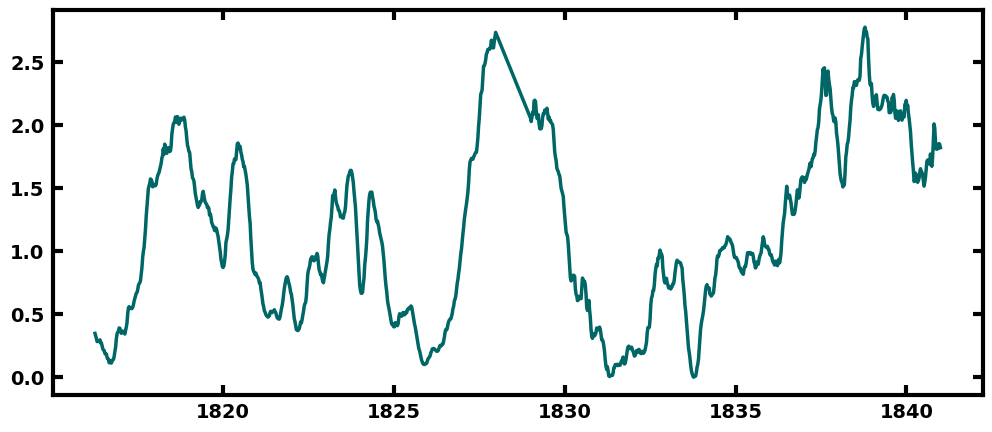

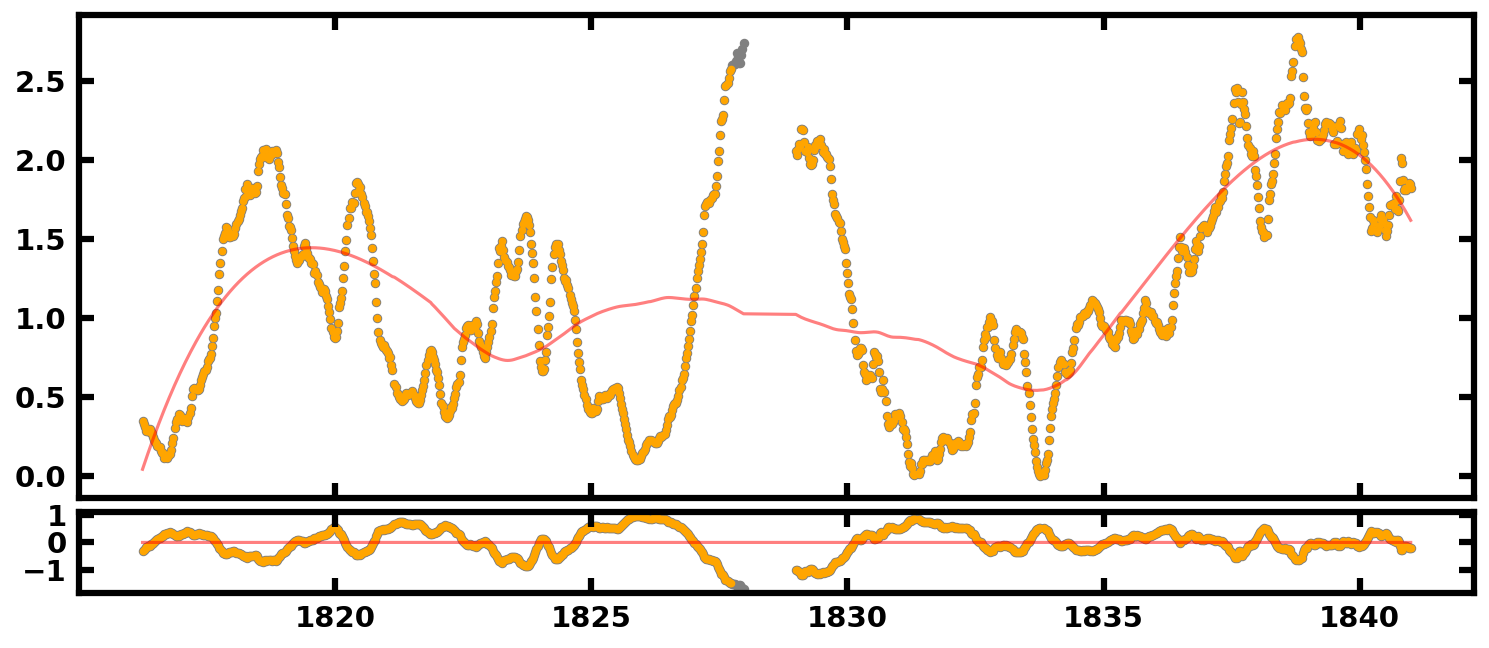

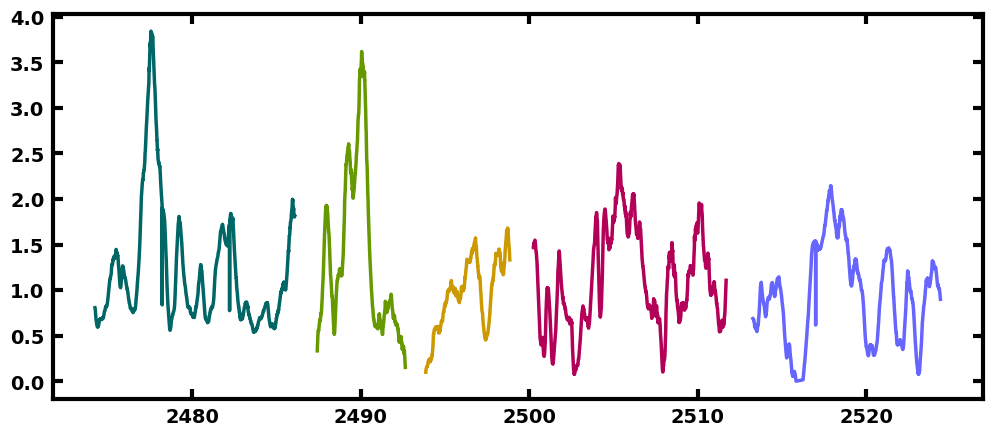

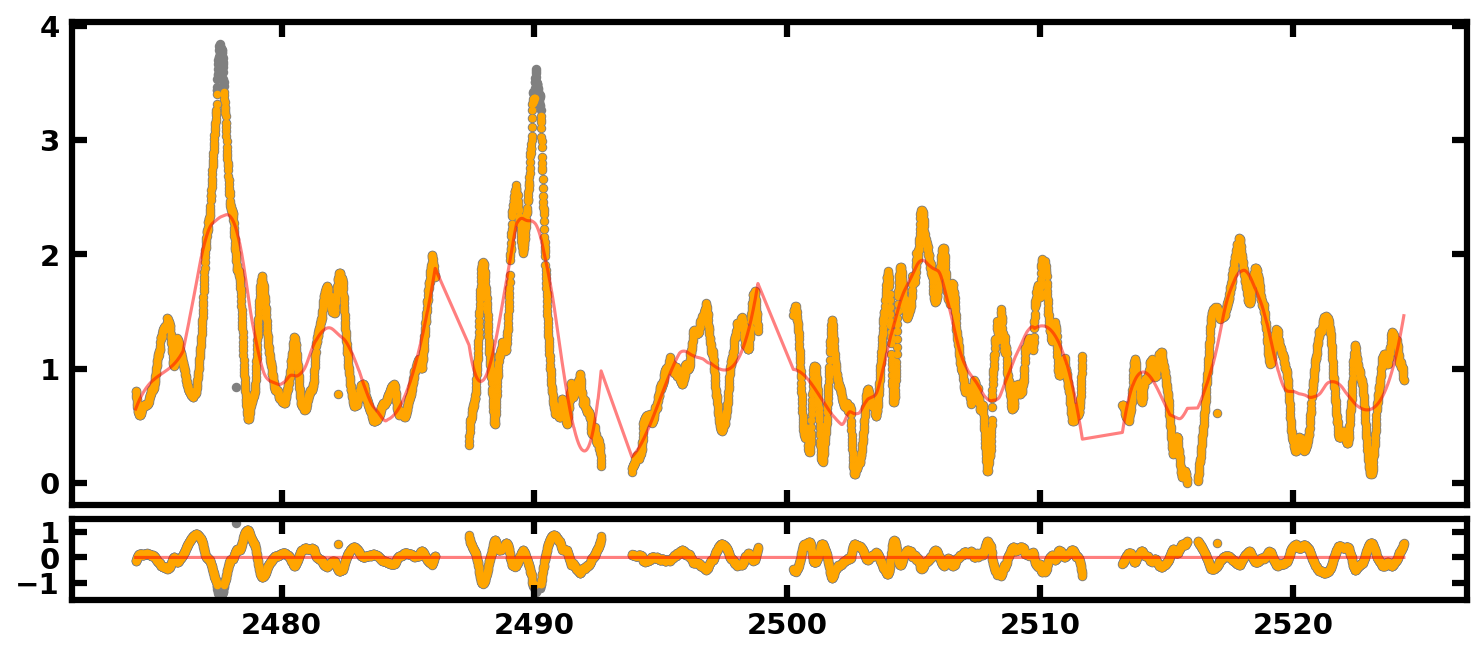

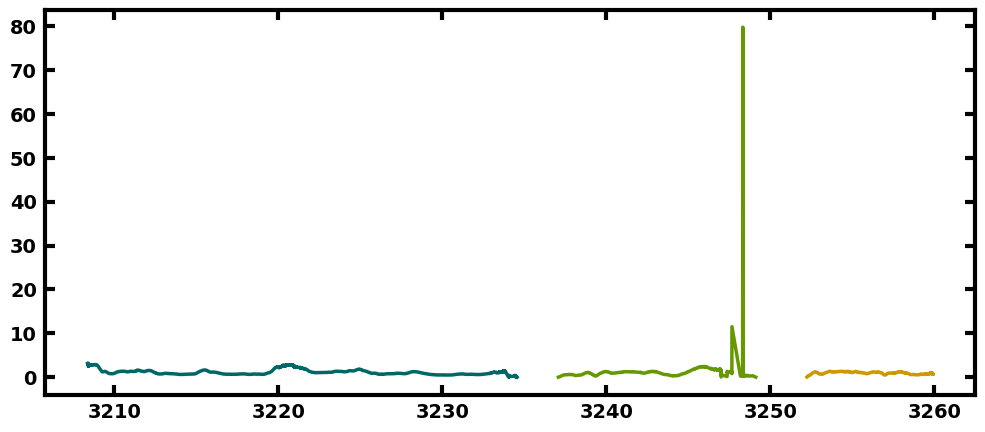

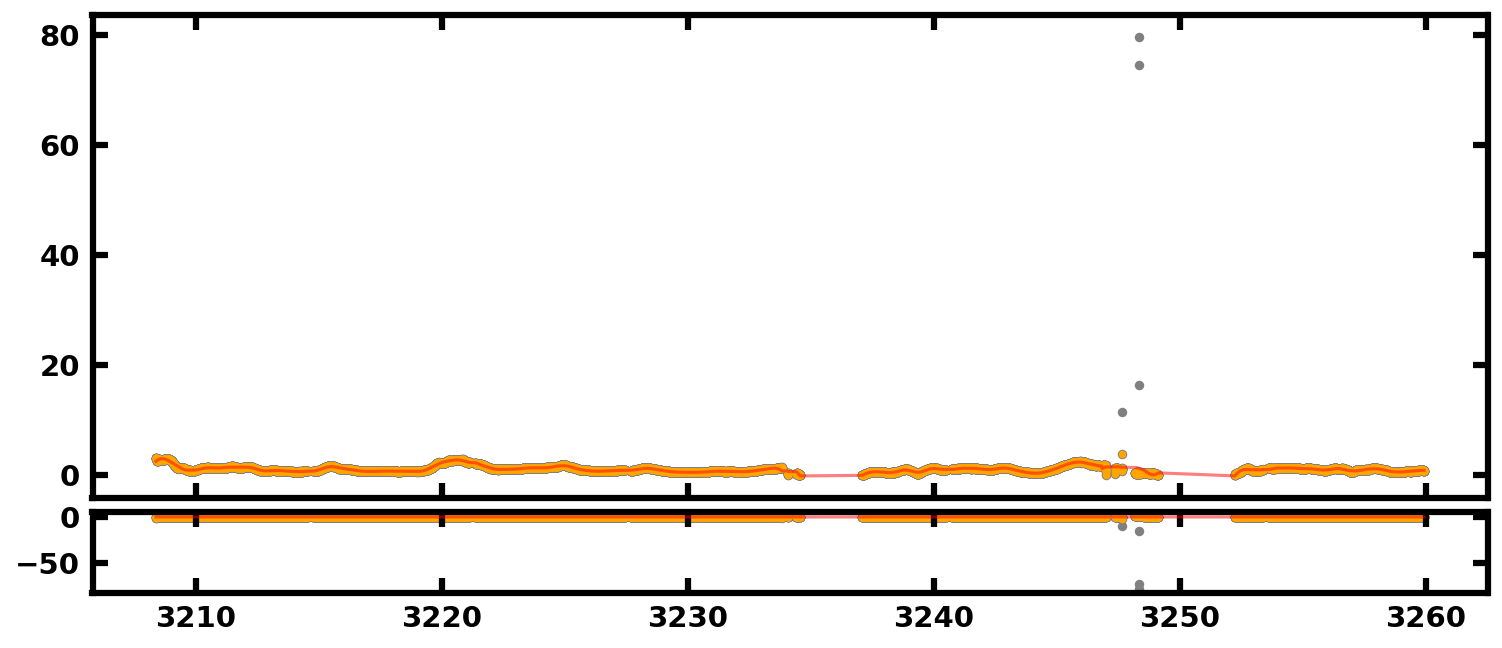



DO MISSION:  K2

SEARCH_RESULT: 
 SearchResult containing 0 data products. 

issues:  ['2MASS J16041893-2430392', 'GI Tau', 'IRAS 16246-2430']


In [77]:
# range_template = [[0, startgap1], [endgap1, startgap2], [endgap2, -1]]

mask_dict = {'TESS Sector 64': {'2MASS J11004022-7619280': [[0, 3062.4], [3063.0, -1]]
                                },
             'TESS Sector 44': {'2MASS J04422101+2520343': [[0, 2512.0], [2514.4, -1]]
                                },
             'TESS Sector 12': {'Sz 113': [[0, 1627.0], [1627.1, -1]]
                                },
             'TESS Sector 70': {'2MASS J04334465+2615005': [[3208.0, 3220.0], [3223.0, -1]],
                                'V409 Tau': [[3209.0, 3221.0], [3222.0, -1]],
                                'DM Tau': [[3209.0, 3221.0], [3222.0, -1]]
                                },
             'TESS Sector 71': {'2MASS J04334465+2615005': [[3235.0, 3247.0], [3248.5, -1]],
                                'V409 Tau': [[3234.5, 3246.5], [3248.0, -1]],
                                'DM Tau': [[3234.5, 3246.5], [3248.0, -1]]
                                },
             'K2 Campaign 02': {'DoAr 25': [[0, 2064.0], [2064.5, 2104.5], [2107.5, 2126.0]],
                                'WSB 52': [[0, 2064.0], [2064.5, 2104.5], [2107.5, 2126.0]],
                                'WSB 63': [[0, 2104.5], [2107.5, 2126.0]],
                                'EM* SR 4': [[0, 2106.5], [2107.5, -1]],
                                'Elias 2-24': [[2067, 2106.5], [2107.5, -1]],
                                'Elias 2-27': [[0, 2105.0], [2108.0, -1]],
                                '2MASS J16081566-2222199': [[2071.5, 2092.0], [2093.0, -1]]
                                },
             }



completed = []
multiple = []
issues = []

# ---------- DO TARGET TEST ONLY? ---------- #
do_test_target_only = False

if do_test_target_only == True:
    targets_with_lightcurves.append(test_target)
    target_list = [test_target] 
# ------------------------------------------ #

print('Target List: \n', target_list)

stitch_sectors = True

track_completed = False

do_final_sample = False

do_clean = True
show_clean_plots = True

show_lombscargle_period_identification = False

plot_extras = True

peak_signals = {'target': [],
                'signals': [],
                }


# lcdata = {'CX Tau': {'TESS Sectors 43 & 44': {'lightcurve': [],
#                                               'periodogram': [],
#                                               'phasecurve': [],
#                                               'signal': [],
#                                               'BJDREF': [],
#                                               },
#                     }
#          }

lcdata = {}


for target_i, target in enumerate(target_list):

    if target in targets_with_lightcurves:
        in_final_sample = True
    else:
        in_final_sample = False



    if ((target not in completed) and (target not in issues)):

        print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n', target, '\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

        if in_final_sample == True:
            lcdata[target] = {}
        
        for do_mission in ['TESS', 'K2']:

            print('\n\nDO MISSION: ', do_mission)

            if do_mission == 'K2':
                mission_name = 'K2'
                author_name = 'K2'
                exptime = 1800
                issues = ['2MASS J16041893-2430392', 'GI Tau', 'IRAS 16246-2430']
            if do_mission == 'TESS':
                mission_name = 'TESS'
                author_name = 'SPOC'
                exptime = 120
                issues = ['DK Tau', 'HN Tau', 'HV Tau', 'UX Tau', 'UZ Tau', 'V710 Tau']

            if do_mission == 'TESS':
                if target in TESS_SPOC_targets:
                    author_name = 'TESS-SPOC'
                elif target in TESS_QLP_targets:
                    author_name = 'QLP'
                elif target in TESS_CDIPS_targets:
                    author_name = 'CDIPS'
                elif target in TESS_PATHOS_targets:
                    author_name = 'PATHOS'
                else:
                    author_name = 'SPOC'

            if do_mission == 'K2':
                if target in K2_K2SFF_targets:
                    author_name = 'K2SFF'
                elif target in K2_EVEREST_targets:
                    author_name = 'EVEREST'
                else:
                    author_name = 'K2'


            if (target == 'DR Tau') and (author_name == 'K2'):
                search_result = lk.search_lightcurve(target, mission=mission_name, author=author_name, exptime=exptime)
                search_result = search_result[search_result.target_name == 'ktwo246923113']

            elif (author_name == 'K2SFF') or (author_name == 'EVEREST'):
                try:
                    search_result = lk.search_lightcurve(target, mission=mission_name, author=author_name, exptime=exptime)
                except:
                    print('\nIssue getting a K2SFF or EVEREST search_result.\n')
                    issues.append(target)
                    continue
            elif (author_name == 'SPOC') or (author_name == 'K2'):
                try:
                    search_result = lk.search_lightcurve(target, mission=mission_name, author=author_name, exptime=exptime)
                except:
                    print('\nIssue getting a SPOC or K2 search_result.\n')
                    issues.append(target)
                    continue
            elif (author_name == 'TESS-SPOC') or (author_name == 'QLP'):
                try:
                    search_result = lk.search_lightcurve(target, mission=mission_name, author=author_name)
                except:
                    print('\nIssue getting a TESS-SPOC or QLP search_result.\n')
                    issues.append(target)
                    continue



            print('\nSEARCH_RESULT: \n', search_result, '\n')


            if len(search_result) >= 1:
                multiple.append(target)

                lc_time_stitch = []
                lc_flux_stitch = []
                lc_flux_err_stitch = []
                lc_mission_stitch = []
                lc_time_blocks = []
                lc_flux_blocks = []
                lc_flux_err_blocks = []
                lc_mission_blocks = []


                mission_nums = []
                for mission_j in range(len(search_result.mission)):
                    if do_mission == 'TESS':
                        mission_num_str = ''
                        for char_j in search_result.mission[mission_j]:
                            if char_j.isnumeric():
                                mission_num_str += str(int(char_j))
                    if do_mission == 'K2':
                        mission_num_str = search_result.mission[mission_j].split(' ')[-1]
                    if mission_num_str[0] == '0':
                        mission_num_str = mission_num_str[1:]

                    mission_nums.append(int(mission_num_str))

                mission_sets = []
                mission_setnums = []
                where_new_mission_set = np.where(np.diff(mission_nums) > 1)[0] + 1
                for mission_k in range(len(mission_nums)):
                    if mission_k == 0:
                        m_set = [search_result.mission[mission_k]]
                        m_setnum = [mission_nums[mission_k]]
                        if len(mission_nums) == 1:
                            mission_sets.append(m_set)
                            mission_setnums.append(m_setnum)


                    elif mission_k in where_new_mission_set:
                        mission_sets.append(m_set)
                        mission_setnums.append(m_setnum)
                        m_set = [search_result.mission[mission_k]]
                        m_setnum = [mission_nums[mission_k]]

                    elif mission_k == len(mission_nums) - 1:
                        m_set.append(search_result.mission[mission_k])
                        m_setnum.append(mission_nums[mission_k])
                        mission_sets.append(m_set)
                        mission_setnums.append(m_setnum)
                        
                    else:
                        m_set.append(search_result.mission[mission_k])
                        m_setnum.append(mission_nums[mission_k])

                if do_mission == 'TESS':
                    if target == 'V1094 Sco':
                        mission_sets = [['TESS Sector 39'], ['TESS Sector 65']]
                        mission_setnums = [['39'], ['65']]

                    if target == 'RY Lup':
                        mission_sets = [['TESS Sector 12']]
                        mission_setnums = [['12']]

                    if target == 'RX J1615.3-3255':
                        mission_sets = [['TESS Sector 12'], ['TESS Sector 39'], ['TESS Sector 65']]
                        mission_setnums = [['12'], ['39'], ['65']]

                    if target == 'Sz 111':
                        mission_sets = [['TESS Sector 12'], ['TESS Sector 39'], ['TESS Sector 65']]
                        mission_setnums = [['12'], ['39'], ['65']]

                    if target == 'DR Tau':
                        mission_sets = [['TESS Sector 43', 'TESS Sector 44'], ['TESS Sector 70']]
                        mission_setnums = [['43', '44'], ['71']]

                    # if target == 'V409 Tau':
                    #     mission_sets = [['TESS Sector 43'], ['TESS Sector 44']]
                    #     mission_setnums = [['43'], ['44']]

                    if target == 'GW Lup':
                        mission_sets = [['TESS Sector 12'], ['TESS Sector 65']]
                        mission_setnums = [['12'], ['65']]

                    if target == '2MASS J16090141-3925119':
                        mission_sets = [['TESS Sector 39'], ['TESS Sector 65']]
                        mission_setnums = [['39'], ['65']]

                    if target == 'SY Cha':
                        mission_sets = [['TESS Sector 11', 'TESS Sector 12'], ['TESS Sector 38', 'TESS Sector 39'], ['TESS Sector 64', 'TESS Sector 65', 'TESS Sector 66']]
                        mission_setnums = [['11', '12'], ['38', '39'], ['64', '65', '66']]

                    if target == '2MASS J04202555+2700355':
                        if author_name == 'SPOC':
                            mission_sets = [['TESS Sector 43']]
                            mission_setnums = [['43']]

                    if target == 'Sz 76':
                        if author_name == 'QLP':
                            mission_sets = [['TESS Sector 12']]
                            mission_setnums = [['12']]

                    if target == 'CT Cha':
                        if author_name == 'QLP':
                            mission_sets = [['TESS Sector 39'], ['TESS Sector 64', 'TESS Sector 65']]
                            mission_setnums = [['39'], ['64', '65']]

                    if target == '2MASS J16124373-3815031':
                        if author_name == 'QLP':
                            mission_sets = [['TESS Sector 12'], ['TESS Sector 39'], ['TESS Sector 65']]
                            mission_setnums = [['12'], ['39'], ['65']]

                    if target == 'RX J1556.0-3655':
                        mission_sets = [['TESS Sector 12'], ['TESS Sector 65']]
                        mission_setnums = [['12'], ['65']]



                print('Mission Sets: ', mission_sets)
                print('Mission Setnums: ', mission_setnums)

                
                lc_time_sets = []
                lc_flux_sets = []
                lc_flux_err_sets = []
                lc_mission_set_strs = []
                lc_BJDREFs = []
                for mission_set_i, mission_set in enumerate(mission_sets):
                    lc_time_set = []
                    lc_flux_set = []
                    lc_flux_err_set = []
                    lc_mission_setnums = ''
                    for mission_i, mission in enumerate(mission_set):

                        if target == 'DR Tau':
                            search_mission = search_result[search_result.mission == mission][0]
                        elif (target == 'HD 143006') and (mission == 'K2 Campaign 02'):
                            search_mission = search_result[search_result.mission == mission][0]
                        else:
                            search_mission = search_result[search_result.mission == mission]

                        # --------------- DOWNLOAD LIGHTCURVE ---------------- # 
                        try:
                            lc = search_mission.download().remove_nans()
                        except:
                            print('\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                            print('MISSION: ', mission)
                            print('\nIssue dowloading target lightcurve.\n')
                            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n')
                            # issues.append(target)
                            # continue


                        # # print('lc: ')
                        # print(lc)
                        # # print(lc.meta)
                        # print(mission)
                        # print(lc.columns)
                        # print('-------')

                        time_download = lc.time
                        if author_name == 'QLP':
                            try:
                                pdcsap_flux_download = lc.flux
                            except:
                                print('\nIssue reading QLP flux of target.\n')
                                issues.append(target)
                                continue
                            pdcsap_flux_err_download = lc.flux_err
                        elif author_name == 'K2SFF':
                            try:
                                pdcsap_flux_download = lc.flux
                            except:
                                print('\nIssue reading K2SFF flux of target.\n')
                                issues.append(target)
                                continue
                            pdcsap_flux_err_download = lc.flux_err
                        elif author_name == 'CDIPS':
                            try:
                                pdcsap_flux_download = lc.flux
                            except:
                                print('\nIssue reading CDIPS flux of target.\n')
                                issues.append(target)
                                continue
                            pdcsap_flux_err_download = lc.flux_err
                        elif author_name == 'PATHOS':
                            try:
                                pdcsap_flux_download = lc.flux
                            except:
                                print('\nIssue reading PATHOS flux of target.\n')
                                issues.append(target)
                                continue
                            pdcsap_flux_err_download = lc.flux_err
                        elif author_name == 'EVEREST':
                            try:
                                pdcsap_flux_download = lc.fcor
                            except:
                                print('\nIssue reading EVEREST flux of target.\n')
                                issues.append(target)
                                continue
                            pdcsap_flux_err_download = lc.flux_err
                        
                        else: # Default SPOC or PDCSAP pipeline products
                            try:
                                pdcsap_flux_download = lc.pdcsap_flux
                            except:
                                print('\nIssue reading pdcsap_flux of target.\n')
                                issues.append(target)
                                continue
                            pdcsap_flux_err_download = lc.pdcsap_flux_err

                        lc_time = time_download.value[np.isnan(pdcsap_flux_download.value) == False]
                        lc_flux = pdcsap_flux_download.value[np.isnan(pdcsap_flux_download.value) == False]
                        lc_flux_err = pdcsap_flux_err_download.value[np.isnan(pdcsap_flux_download.value) == False]

                        # -------------------- quick test print lc ---------------------- #
                        quick_print_lc = [lc_time, lc_flux, lc_flux_err]
                        quick_print_lc = np.transpose(quick_print_lc)
                        # print(mission)
                        # print(quick_print_lc, '\n')
                        # print(lc_time, '\n', lc_flux, '\n', lc_flux_err, '\n')
                        # --------------------------------------------------------------- #

                        # nan_err_targs = ['RX J1615.3-3255', 'SY Cha', 'V1094 Sco', 'DR Tau',
                        #                  '2MASS J04322210+1827426', 'AA Tau', '2MASS J11120327-7637034',
                        #                  '2MASS J16000236-4222145', 'V409 Tau', '2MASS J04334465+2615005',
                        #                  'Sz 76', 'Sz 77', '2MASS J16163345-2521505', 'Sz 98']
                        nan_err_targs = []
                        if target in TESS_QLP_targets or target in K2_EVEREST_targets or target in K2_K2SFF_targets or target in TESS_PATHOS_targets:
                            nan_err_targs.append(target)

                        if target in nan_err_targs:
                            lc_flux_err = [1e-6]*len(lc_time)

                        if mission in mask_dict.keys():
                            temp_time = []
                            temp_flux = []
                            temp_err = []
                            if target in mask_dict[mission].keys():
                                keep_ranges = mask_dict[mission][target]

                                for range_i in range(len(keep_ranges)):
                                    if keep_ranges[range_i][0] == 0:
                                        keep_ranges[range_i][0] = lc_time[0]
                                    if keep_ranges[range_i][1] == -1:
                                        keep_ranges[range_i][1] = lc_time[-1]

                                for keep_range in keep_ranges:
                                    temp_time.extend(lc_time[(lc_time >= keep_range[0]) & (lc_time <= keep_range[1])])
                                    temp_flux.extend(lc_flux[(lc_time >= keep_range[0]) & (lc_time <= keep_range[1])])
                                    temp_err.extend(np.array(lc_flux_err)[(lc_time >= keep_range[0]) & (lc_time <= keep_range[1])])
                                lc_time = np.array(temp_time)
                                lc_flux = np.array(temp_flux)
                                lc_flux_err = np.array(temp_err)
                                
                                # print(' ')
                                # print('KEEP RANGES')
                                # print(keep_ranges)
                                # print(' ')

                        lc_time_set = np.array(np.concatenate((lc_time_set, lc_time)))
                        lc_flux_set = np.array(np.concatenate((lc_flux_set, lc_flux)))
                        lc_flux_err_set = np.array(np.concatenate((lc_flux_err_set, lc_flux_err)))
                        
                        
                        if mission_i == 0:
                            lc_mission_setnums += str(mission_setnums[mission_set_i][mission_i])
                            if do_mission == 'K2': 
                                lc_mission_setnums = 'K2 Campaign ' + lc_mission_setnums
                            if do_mission == 'TESS': 
                                lc_mission_setnums = 'TESS Sector ' + lc_mission_setnums
                        elif mission_i > 0:
                            lc_mission_setnums += ' & ' + str(mission_setnums[mission_set_i][mission_i])
                    


                    if (target == '2MASS J04141760+2806096'):
                        temp_time = []
                        temp_flux = []
                        temp_err = []
                        for time_i in range(len(lc_time_set)):
                            if lc_time_set[time_i] not in temp_time:
                                temp_time.append(lc_time_set[time_i])
                                temp_flux.append(lc_flux_set[time_i])
                                temp_err.append(lc_flux_err_set[time_i])

                        lc_time_set = np.array(temp_time)
                        lc_flux_set = np.array(temp_flux)
                        lc_flux_err_set = np.array(temp_err)

                    clean_time, clean_flux, clean_flux_err = clean_lightcurve(xdata=lc_time_set, ydata=lc_flux_set, ydata_err=lc_flux_err_set, itime=exptime, which_target=target, which_telescope=do_mission, do_clean=do_clean, do_plot=show_clean_plots)

                    lc_time_sets.append(clean_time)
                    lc_flux_sets.append(clean_flux)
                    lc_flux_err_sets.append(clean_flux_err)
                    lc_mission_set_strs.append(lc_mission_setnums)
                    lc_BJDREFs.append(lc.meta['BJDREFI'])

                    per_x, per_y, peak_sig, pse_x, pse_y, pse_x_binned, pse_y_binned, pse_y_err_binned = compute_periodogram_and_phase_curve(lcv_x=clean_time, lcv_y=clean_flux, lcv_y_err=clean_flux_err, mission_str=do_mission, target=target, plot_period_identification=show_lombscargle_period_identification)

                    peak_signals['target'].append(target)
                    peak_signals['signals'].append([peak_sig[0], peak_sig[1]])

                    if '&' in lc_mission_setnums: 
                        if do_mission == 'K2':
                            lc_mission_setnums.replace('Campaign', 'Campaigns')
                        if do_mission == 'TESS': 
                            lc_mission_setnums = lc_mission_setnums[0:11] + 's ' + lc_mission_setnums[12:]

                    
                    if (in_final_sample == True):
                        lcdata[target][lc_mission_setnums] = {}

                        lcdata[target][lc_mission_setnums]['lightcurve'] = [clean_time, clean_flux, clean_flux_err]
                        lcdata[target][lc_mission_setnums]['periodogram'] = [per_x, per_y]
                        lcdata[target][lc_mission_setnums]['phasecurve'] = [pse_x, pse_y, pse_x_binned, pse_y_binned]
                        lcdata[target][lc_mission_setnums]['signal'] = peak_sig
                        lcdata[target][lc_mission_setnums]['BJDREF'] = lc.meta['BJDREFI']
                        lcdata[target][lc_mission_setnums]['Final Sample?'] = in_final_sample



    if track_completed == True:
        completed.append(target)

print('issues: ', issues)






len_total:  1
max height:,  19.5
[0,1]  9.00
CW Tau
figsize: [13.  9.]
axis height: 2.1749999999999994


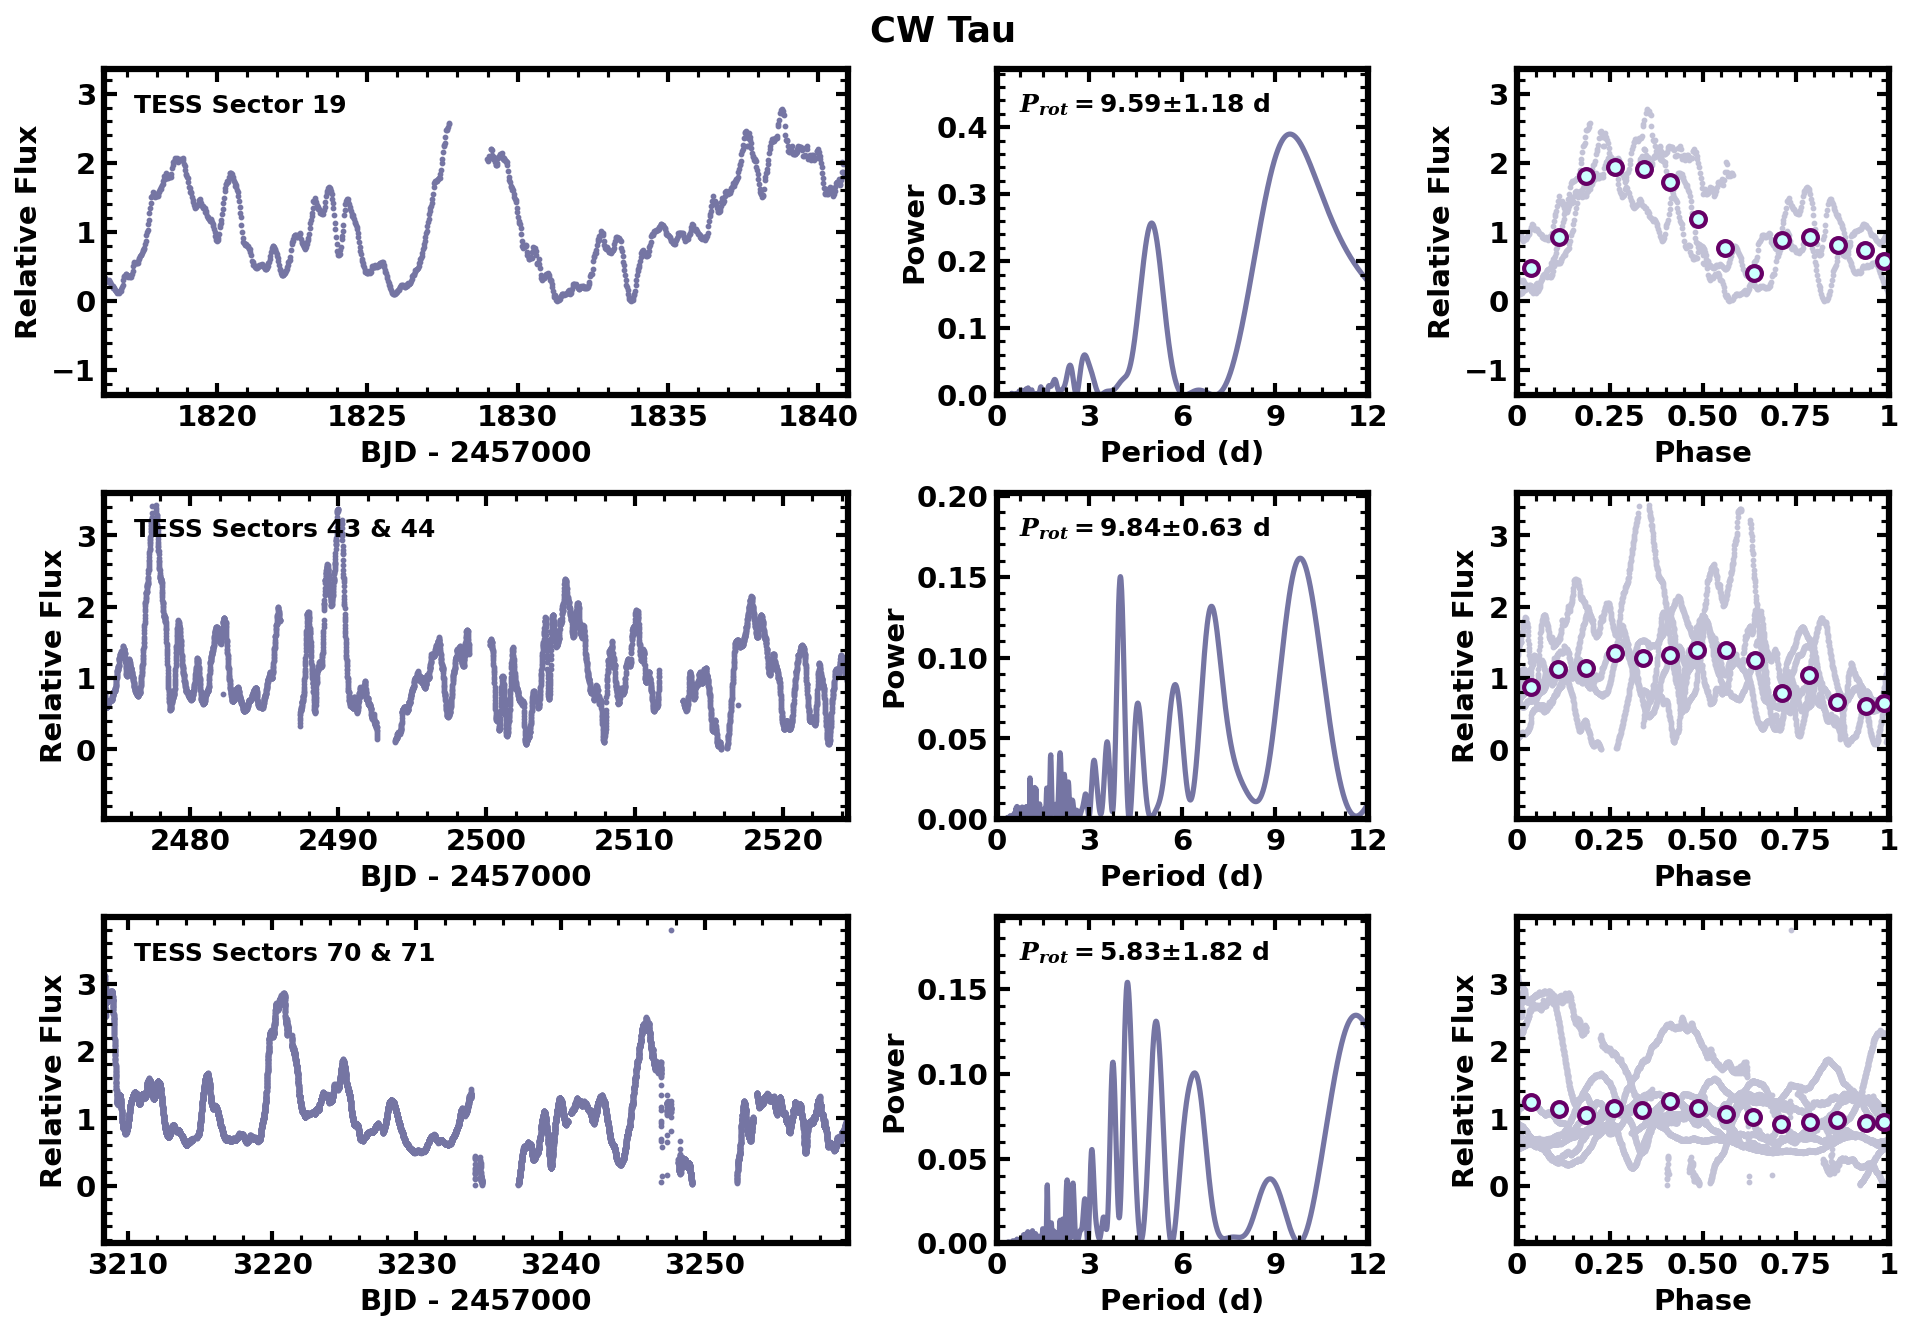

In [78]:
do_savefig = True

plot_publication_lightcurves(target_lc_data=lcdata, savefig=do_savefig)

In [79]:
# bep = weighted_mean(meas=[6.00, 5.94, 6.15], meas_err=[0.27, 0.33, 0.28])
bep = weighted_mean(meas=[5.83, 6.06], meas_err=[0.29, 0.25])
print(bep)

(5.96194406548431, 0.1893524904001442)


In [80]:
bep = weighted_mean(meas=[78, 80, 80, 82, 78], meas_err=[1, 1, 1, 1, 1])
print(bep)

(79.6, 0.4472135954999579)


In [63]:
peak_signals
peak_signals_df = pd.DataFrame(peak_signals)

targs = unique(peak_signals_df['target'].values)

for object_i in range(len(targs)):

    peaks = []
    peak_errs = []

    target_peak_signals = peak_signals_df[peak_signals_df['target'] == targs[object_i]]
    target_peak_signals['signals']

    target_signals = target_peak_signals['signals'].values
    for peak_i in range(len(target_signals)):
        peaks.append(target_signals[peak_i][0])
        peak_errs.append(target_signals[peak_i][1])

    peak_signals_wmean, peak_signals_wmean_err = weighted_mean(meas=peaks, meas_err=peak_errs)

    print(peak_signals['target'][object_i])
    print('{:.2f} +/- {:.2f}\n'.format(peak_signals_wmean, peak_signals_wmean_err))

RX J1556.0-3655
5.77 +/- 0.31



In [ ]:
def weighted_mean(meas, meas_err):
    try:
        weight = 1./(np.array(meas_err)**2)
    except:
        print('Error calculating weighted mean!')
        print(meas, ',', meas_err)
    else:
        w_mean = sum(weight * np.array(meas)) / sum(weight)
        w_mean_err = 1./np.sqrt(sum(weight))

    return w_mean, w_mean_err

In [ ]:


for object_i in range(len(peak_signals['target'])):

    target_signals = np.transpose(peak_signals['signals'][object_i])
    peak_signals_wmean, peak_signals_wmean_err = weighted_mean(meas=target_signals[0], meas_err=target_signals[1])

    print(peak_signals['target'][object_i])
    print('{:.2f} +/- {:.2f}\n'.format(peak_signals_wmean, peak_signals_wmean_err))


In [ ]:
# import lightkurve as lk
# # ---------------------------------------------------------------------------------------------- #
# # DISPLAY THE FULL LIGHTKURVE SEARCH RESULT FOR A SPECIFIC TARGET TO VISUALIZE WHICH DATA
# # PRODUCTS ARE AVAILABLE FOR THAT TARGET. 
# # ---------------------------------------------------------------------------------------------- #

# # ----------- SPECIFY TARGET AND MISSION ----------- #
# choose_target = 'LkCa 15'
# choose_mission = 'TESS'

# # ----------- GENERATE AND DISPLAY SEARCH RESULT ----------- #
# search_result = lk.search_lightcurve(choose_target, mission=choose_mission)
# print(search_result, '\n')

# # ---------------------------------------------------------------------------------------------- #
# # MANY AUTHORS ARE ASSOCIATED WITH MULTIPLE MISSIONS ("SECTORS" FOR TESS, "CAMPAIGNS" FOR K2), 
# # TO DOWNLOAD A LIGHTCURVE FOR A SPECIFIC AUTHOR AND MISSION, DEFINE THOSE VARIABLES AND TRUNCATE
# # THE SEARCH RESULTS TABLE SO THAT IT INCLUDES ONLY THAT AUTHOR AND MISSION YOU ARE INTERESTED
# # IN. EXAMPLE BELOW:
# # ---------------------------------------------------------------------------------------------- #

# # ----------- SPECIFY AUTHOR AND MISSION ----------- #
# choose_author = 'SPOC'
# choose_mission = 'TESS Sector 44'

# # ----------- TRUNCATE THE SEARCH RESULT FOR SPECIFIC AUTHOR TO INCLUDE ONLY THE MISSION YOU ARE INTERESTED IN ----------- #
# search_result_for_specific_author_and_mission = search_result[(search_result.mission == choose_mission) & (search_result.author == choose_author)][0]

# # ----------- PRINT TRUNCATED SEARCH RESULTS TABLE TO VERIFY THAT THE CORRECT INFORMATION WAS SPECIFIED ----------- #
# print(search_result_for_specific_author_and_mission, '\n')

# # ----------- DOWNLOAD THE LIGHTCURVE ASSOCIATED WITH YOUR TRUNCATED SEARCH RESULTS TABLE ----------- #
# lc_for_specific_author_and_mission = search_result_for_specific_author_and_mission.download()

# # ---------------------------------------------------------------------------------------------- #
# # THE LIGHTCURVE OBJECT CAN BE THOUGHT OF AS A TABLE TOO, AND THE CONTENT OF THE LIGHTCURVE OBJECT
# # CAN VARY FROM AUTHOR TO AUTHOR. PRINT THE LIGHTCURVE OBJECT'S COLUMNS TO GAIN A CLEARER SENSE
# # FOR THE EXACT DATA PRODUCTS DIFFERENT AUTHORS' LIGHTCURVE OBJECTS CONTAIN.
# # ---------------------------------------------------------------------------------------------- #

# # ----------- DISPLAY COLUMNS IN LIGHTCURVE OBJECT ----------- #
# print(lc_for_specific_author_and_mission.columns, '\n')